## 1. Pendahuluan

**Convolutional Neural Networks (CNNs)** adalah arsitektur neural network yang dirancang khusus untuk **computer vision**.

### Mengapa CNN?

Fully connected networks untuk images memiliki masalah:
- **Terlalu banyak parameters**: Image 224×224×3 = 150,528 inputs
- **Kehilangan spatial information**: Pixel yang berdekatan penting
- **Tidak translation invariant**: Object di lokasi berbeda = pattern berbeda

### Keunggulan CNN:
- ✅ **Parameter sharing**: Convolution kernels dipakai di seluruh image
- ✅ **Spatial hierarchy**: Deteksi features dari simple → complex
- ✅ **Translation invariance**: Deteksi pattern di mana saja
- ✅ **Jauh lebih sedikit parameters**

In [27]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## 2. Convolutional Layers

**Convolution** adalah operasi matematika yang mengaplikasikan filter (kernel) ke input image.

### 2.1 Cara Kerja Convolution

**Convolution Operation:**
1. Sliding window (kernel/filter) bergerak di atas image
2. Element-wise multiplication antara kernel dan region
3. Sum hasil multiplication → single output value
4. Repeat untuk seluruh image

**Formula:**
$$
(I * K)(i, j) = \sum_m \sum_n I(i+m, j+n) \cdot K(m, n)
$$

Dimana:
- $I$ = input image
- $K$ = kernel/filter
- $*$ = convolution operation

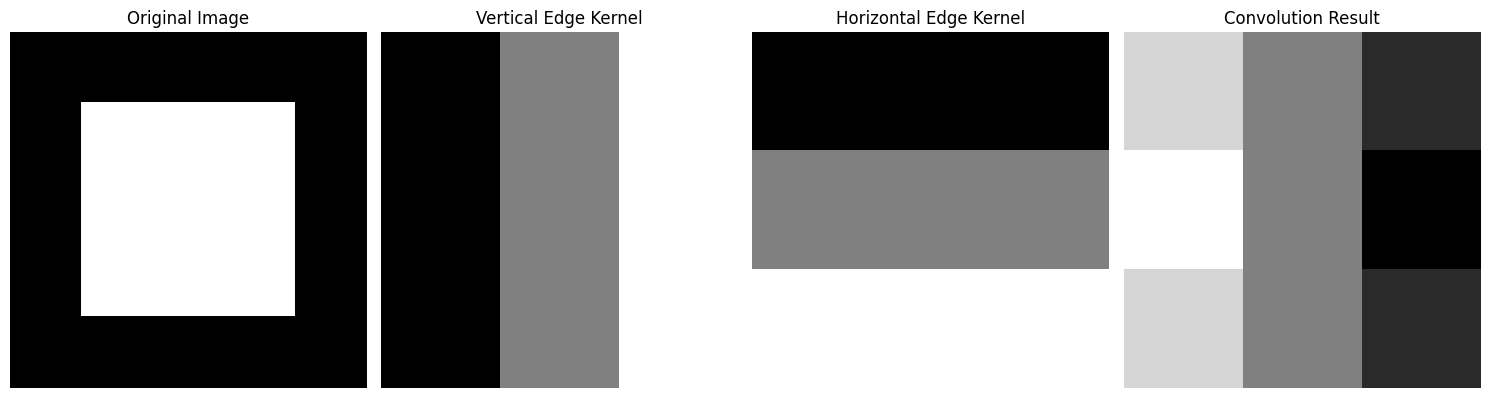

In [28]:
# Visualisasi simple convolution
def visualize_convolution():
    # Simple 5x5 image
    image = np.array([
        [0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0]
    ])
    
    # Vertical edge detector kernel
    kernel_vertical = np.array([
        [-1, 0, 1],
        [-1, 0, 1],
        [-1, 0, 1]
    ])
    
    # Horizontal edge detector kernel
    kernel_horizontal = np.array([
        [-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]
    ])
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(kernel_vertical, cmap='gray')
    axes[1].set_title('Vertical Edge Kernel')
    axes[1].axis('off')
    
    axes[2].imshow(kernel_horizontal, cmap='gray')
    axes[2].set_title('Horizontal Edge Kernel')
    axes[2].axis('off')
    
    # Apply convolution (manual)
    from scipy.signal import correlate2d
    result = correlate2d(image, kernel_vertical, mode='valid')
    
    axes[3].imshow(result, cmap='gray')
    axes[3].set_title('Convolution Result')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_convolution()

### 2.2 Key Hyperparameters

| Parameter | Deskripsi | Typical Values |
|-----------|-----------|----------------|
| **Filters** | Jumlah kernels (output channels) | 32, 64, 128, 256 |
| **Kernel Size** | Ukuran filter (height × width) | 3×3, 5×5, 7×7 |
| **Strides** | Step size saat sliding | 1, 2 |
| **Padding** | Add zeros di border | 'valid', 'same' |

**Output Size Formula:**
$$
\text{output\_size} = \left\lfloor \frac{\text{input\_size} - \text{kernel\_size} + 2 \times \text{padding}}{\text{stride}} \right\rfloor + 1
$$

In [29]:
# Conv2D layer di Keras
conv_layer = layers.Conv2D(
    filters=32,           # Number of output filters
    kernel_size=(3, 3),   # 3x3 kernel
    strides=(1, 1),       # Move 1 pixel at a time
    padding='same',       # Keep same spatial dimensions
    activation='relu',
    input_shape=(28, 28, 1)  # Height, Width, Channels
)

# Test dengan dummy input
dummy_input = tf.random.normal([1, 28, 28, 1])  # Batch of 1 image
output = conv_layer(dummy_input)

print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Number of parameters: {conv_layer.count_params()}")

Input shape: (1, 28, 28, 1)
Output shape: (1, 28, 28, 32)
Number of parameters: 320


In [30]:
# Perbandingan padding='valid' vs 'same'
input_img = tf.random.normal([1, 28, 28, 1])

conv_valid = layers.Conv2D(32, (3, 3), padding='valid')
conv_same = layers.Conv2D(32, (3, 3), padding='same')

output_valid = conv_valid(input_img)
output_same = conv_same(input_img)

print("Padding comparison:")
print(f"  Input:         {input_img.shape}")
print(f"  'valid' output: {output_valid.shape}  (no padding, size reduces)")
print(f"  'same' output:  {output_same.shape}   (padding added, size maintained)")

Padding comparison:
  Input:         (1, 28, 28, 1)
  'valid' output: (1, 26, 26, 32)  (no padding, size reduces)
  'same' output:  (1, 28, 28, 32)   (padding added, size maintained)


### 2.3 Visualisasi Filters

In [31]:
# Load Fashion MNIST
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize dan reshape
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train[..., np.newaxis]  # Add channel dimension
X_test = X_test[..., np.newaxis]

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


In [32]:
# Visualisasi feature maps
def visualize_feature_maps(model, image, layer_name):
    # Create model that outputs intermediate layer
    layer_output = model.get_layer(layer_name).output
    feature_model = keras.Model(inputs=model.input, outputs=layer_output)
    
    # Get feature maps
    feature_maps = feature_model.predict(image[np.newaxis, ...])
    
    # Plot
    n_features = min(16, feature_maps.shape[-1])  # Show max 16 filters
    size = feature_maps.shape[1]
    
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i in range(n_features):
        ax = axes[i // 4, i % 4]
        ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')
    
    plt.suptitle(f'Feature Maps from {layer_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

print("Feature map visualization function ready!")

Feature map visualization function ready!


## 3. Pooling Layers

**Pooling** mengurangi spatial dimensions (downsampling) sambil mempertahankan informasi penting.

### 3.1 Max Pooling

Mengambil nilai **maximum** dari setiap pooling window.

**Keuntungan:**
- Mengurangi computational cost
- Mengurangi overfitting
- Memberikan translational invariance
- Mempertahankan features yang paling kuat

In [33]:
# Max Pooling visualization
feature_map = np.array([
    [1, 3, 2, 4],
    [5, 6, 1, 3],
    [2, 8, 3, 1],
    [4, 7, 2, 5]
])

print("Original 4×4 feature map:")
print(feature_map)
print("\nAfter 2×2 Max Pooling:")
print("┌─────┬─────┐")
print(f"│  {feature_map[:2, :2].max()}  │  {feature_map[:2, 2:].max()}  │")
print("├─────┼─────┤")
print(f"│  {feature_map[2:, :2].max()}  │  {feature_map[2:, 2:].max()}  │")
print("└─────┴─────┘")

Original 4×4 feature map:
[[1 3 2 4]
 [5 6 1 3]
 [2 8 3 1]
 [4 7 2 5]]

After 2×2 Max Pooling:
┌─────┬─────┐
│  6  │  4  │
├─────┼─────┤
│  8  │  5  │
└─────┴─────┘


In [34]:
# Max Pooling layer
max_pool = layers.MaxPooling2D(
    pool_size=(2, 2),  # 2x2 window
    strides=2,          # Move 2 pixels
    padding='valid'
)

# Test
input_tensor = tf.random.normal([1, 28, 28, 32])
output = max_pool(input_tensor)

print(f"Input shape:  {input_tensor.shape}")
print(f"Output shape: {output.shape}")
print(f"Size reduction: {input_tensor.shape[1]}×{input_tensor.shape[2]} → {output.shape[1]}×{output.shape[2]}")

Input shape:  (1, 28, 28, 32)
Output shape: (1, 14, 14, 32)
Size reduction: 28×28 → 14×14


### 3.2 Average Pooling dan Global Pooling

In [35]:
# Average Pooling - mengambil rata-rata
avg_pool = layers.AveragePooling2D(pool_size=(2, 2), strides=2)

# Global Average Pooling - average seluruh spatial dimension
global_avg_pool = layers.GlobalAveragePooling2D()

# Global Max Pooling
global_max_pool = layers.GlobalMaxPooling2D()

# Test
input_tensor = tf.random.normal([1, 8, 8, 64])

print(f"Input shape: {input_tensor.shape}")
print(f"\nAfter AveragePooling2D(2,2): {avg_pool(input_tensor).shape}")
print(f"After GlobalAveragePooling2D: {global_avg_pool(input_tensor).shape}")
print(f"After GlobalMaxPooling2D:     {global_max_pool(input_tensor).shape}")

Input shape: (1, 8, 8, 64)

After AveragePooling2D(2,2): (1, 4, 4, 64)
After GlobalAveragePooling2D: (1, 64)
After GlobalMaxPooling2D:     (1, 64)


## 4. CNN Architecture

Typical CNN architecture pattern:

```
Input Image
    ↓
[Conv → ReLU → Pool] × N
    ↓
Flatten
    ↓
[Dense → ReLU] × M
    ↓
Output (Dense + Softmax)
```

In [36]:
# Simple CNN untuk Fashion MNIST
model = keras.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                  input_shape=(28, 28, 1), name='conv1'),
    layers.MaxPooling2D((2, 2), name='pool1'),
    
    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
    layers.MaxPooling2D((2, 2), name='pool2'),
    
    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'),
    layers.MaxPooling2D((2, 2), name='pool3'),
    
    # Classifier
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Compile dan train
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

# Train
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.7655 - loss: 0.6574 - val_accuracy: 0.8598 - val_loss: 0.3723 - learning_rate: 0.0010
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.8577 - loss: 0.3986 - val_accuracy: 0.8827 - val_loss: 0.3059 - learning_rate: 0.0010
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.8806 - loss: 0.3348 - val_accuracy: 0.8977 - val_loss: 0.2748 - learning_rate: 0.0010
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.8921 - loss: 0.3008 - val_accuracy: 0.9030 - val_loss: 0.2562 - learning_rate: 0.0010
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9012 - loss: 0.2710 - val_accuracy: 0.9112 - val_loss: 0.2432 - learning_rate: 0.0010
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.9098 - loss: 0.2521 - val_accuracy: 0.9137 - val_loss: 0.2390 - learning_rate: 0.0010
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.9154 - l

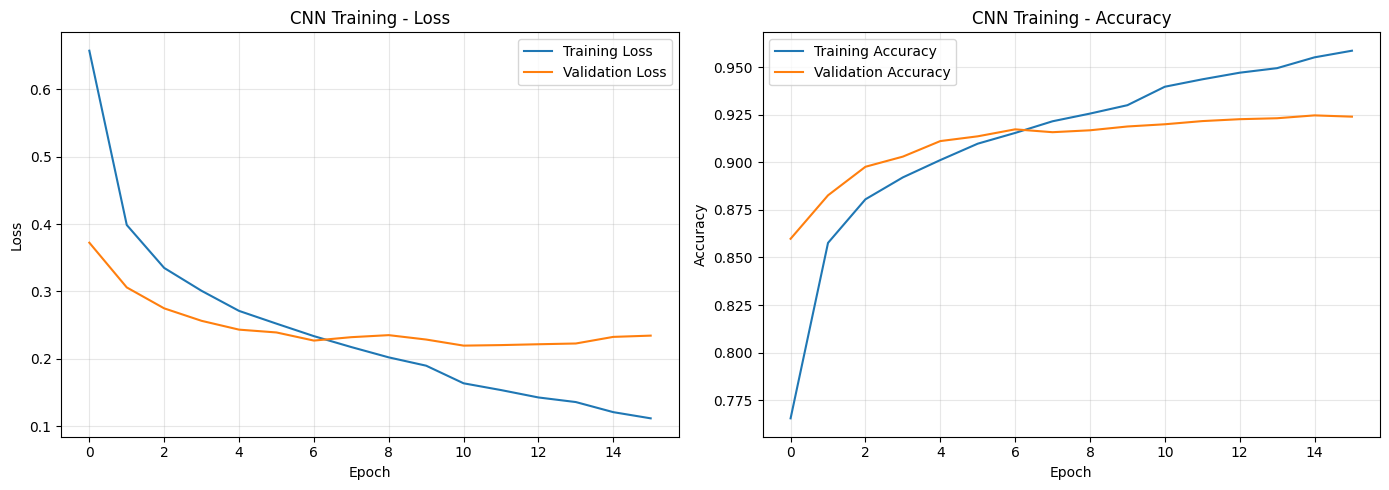

In [38]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('CNN Training - Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('CNN Training - Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")

Test Loss: 0.2315
Test Accuracy: 91.79%


## 5. Classic CNN Architectures

Arsitektur CNN yang terkenal dan influential.

### 5.1 LeNet-5 (1998)

**Yann LeCun** - First successful CNN untuk handwritten digit recognition.

**Architecture:**
- Conv(6) → AvgPool → Conv(16) → AvgPool → FC(120) → FC(84) → FC(10)

In [40]:
# LeNet-5 style architecture (simplified)
def create_lenet5():
    return keras.Sequential([
        layers.Conv2D(6, kernel_size=5, activation='tanh', padding='same', input_shape=(28, 28, 1)),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=5, activation='tanh', padding='valid'),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(120, activation='tanh'),
        layers.Dense(84, activation='tanh'),
        layers.Dense(10, activation='softmax')
    ], name='lenet5')

lenet = create_lenet5()
print("LeNet-5 Architecture:")
lenet.summary()

LeNet-5 Architecture:


Model: "lenet5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

### 5.2 AlexNet (2012)

**Alex Krizhevsky** - Won ImageNet 2012, started Deep Learning revolution.

**Key Innovations:**
- ReLU activation (instead of tanh)
- Dropout regularization
- Data augmentation
- GPU training

### 5.3 VGGNet (2014)

**Visual Geometry Group (Oxford)** - Very deep network dengan small 3×3 filters.

**Key Ideas:**
- Stack multiple 3×3 conv layers (instead of large filters)
- Deeper is better
- Simple and uniform architecture

**VGG-16:** 16 layers, 138M parameters

In [41]:
# VGG-style block
def vgg_block(num_convs, num_filters):
    block = keras.Sequential()
    for _ in range(num_convs):
        block.add(layers.Conv2D(num_filters, kernel_size=3, padding='same', activation='relu'))
    block.add(layers.MaxPooling2D(pool_size=2, strides=2))
    return block

print("VGG-style block function created!")

VGG-style block function created!


### 5.4 ResNet (2015)

**Residual Networks** - Memungkinkan training very deep networks (>100 layers).

**Key Innovation: Skip Connections**
$$
\text{output} = F(x) + x
$$

Dimana $F(x)$ adalah residual mapping yang dipelajari.

**Benefits:**
- Mengatasi vanishing gradient problem
- Lebih mudah dioptimasi
- Won ImageNet 2015

In [42]:
# Residual Block
class ResidualBlock(layers.Layer):
    def __init__(self, filters, strides=1, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.strides = strides
        
        self.conv1 = layers.Conv2D(filters, 3, strides=strides, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters, 3, padding='same')
        self.bn2 = layers.BatchNormalization()
        
        # Shortcut connection (adjust dimensions if needed)
        if strides > 1:
            self.shortcut = keras.Sequential([
                layers.Conv2D(filters, 1, strides=strides),
                layers.BatchNormalization()
            ])
        else:
            self.shortcut = lambda x: x
    
    def call(self, inputs):
        # Main path
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        # Shortcut
        shortcut = self.shortcut(inputs)
        
        # Add and activate
        output = tf.nn.relu(x + shortcut)
        return output

# Test residual block
res_block = ResidualBlock(64)
test_input = tf.random.normal([1, 28, 28, 64])
output = res_block(test_input)
print(f"Residual block input: {test_input.shape}")
print(f"Residual block output: {output.shape}")

Residual block input: (1, 28, 28, 64)
Residual block output: (1, 28, 28, 64)


### 5.5 Inception/GoogLeNet (2014)

**Inception Module** - Multiple filter sizes in parallel.

**Idea:** Let the network choose which filter size is best!
- 1×1 convolutions
- 3×3 convolutions
- 5×5 convolutions
- Max pooling

All concatenated together.

### 5.6 Architecture Comparison

| Architecture | Year | Layers | Parameters | Top-5 Error |
|--------------|------|--------|------------|-------------|
| AlexNet | 2012 | 8 | 60M | 15.3% |
| VGG-16 | 2014 | 16 | 138M | 7.3% |
| GoogLeNet | 2014 | 22 | 6.8M | 6.7% |
| ResNet-50 | 2015 | 50 | 25.6M | 3.6% |
| ResNet-152 | 2015 | 152 | 60.2M | 3.0% |

## 6. Transfer Learning

Menggunakan pretrained models untuk task baru.

### 6.1 Pretrained Models di Keras

In [43]:
# Available pretrained models
print("Keras Applications (Pretrained Models):")
print("- VGG16, VGG19")
print("- ResNet50, ResNet101, ResNet152")
print("- ResNetV2")
print("- InceptionV3, InceptionResNetV2")
print("- Xception")
print("- MobileNet, MobileNetV2, MobileNetV3")
print("- DenseNet")
print("- EfficientNet (B0-B7)")
print("- NASNet")

Keras Applications (Pretrained Models):
- VGG16, VGG19
- ResNet50, ResNet101, ResNet152
- ResNetV2
- InceptionV3, InceptionResNetV2
- Xception
- MobileNet, MobileNetV2, MobileNetV3
- DenseNet
- EfficientNet (B0-B7)
- NASNet


In [44]:
# Load pretrained ResNet50
from tensorflow.keras.applications import ResNet50

# Load with ImageNet weights, tanpa top layers
base_model = ResNet50(
    weights='imagenet',
    include_top=False,  # Tanpa classification layers
    input_shape=(224, 224, 3)
)

print("ResNet50 base model loaded!")
print(f"Number of layers: {len(base_model.layers)}")
print(f"Output shape: {base_model.output_shape}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step
ResNet50 base model loaded!
Number of layers: 175
Output shape: (None, 7, 7, 2048)


### 6.2 Transfer Learning Strategies

In [45]:
# Strategy 1: Feature Extraction (Freeze base model)
base_model.trainable = False  # Freeze all layers

# Add custom classification head
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 classes for Fashion MNIST
])

print("Transfer Learning Model (Feature Extraction):")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights])}")
print(f"Non-trainable parameters: {sum([tf.size(w).numpy() for w in model.non_trainable_weights])}")

Transfer Learning Model (Feature Extraction):
Trainable parameters: 527114
Non-trainable parameters: 23587712


In [46]:
# Strategy 2: Fine-tuning (Unfreeze top layers)
base_model.trainable = True

# Freeze bottom layers, unfreeze top layers
fine_tune_at = 100  # Freeze first 100 layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"\nFine-tuning Strategy:")
print(f"Total layers: {len(base_model.layers)}")
print(f"Frozen layers: {fine_tune_at}")
print(f"Trainable layers: {len(base_model.layers) - fine_tune_at}")


Fine-tuning Strategy:
Total layers: 175
Frozen layers: 100
Trainable layers: 75


In [47]:
# Compile untuk fine-tuning (dengan learning rate kecil)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Small LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled for fine-tuning with lr=1e-5")

Model compiled for fine-tuning with lr=1e-5


## 7. Classification dan Localization

**Classification + Localization:** Predict class AND bounding box.

**Output:**
- Class probabilities (softmax)
- Bounding box coordinates (x, y, width, height)

In [48]:
# Model untuk Classification + Localization
def create_classification_localization_model(num_classes):
    base = keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base.trainable = False
    
    # Shared feature extractor
    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    
    # Classification head
    class_output = layers.Dense(num_classes, activation='softmax', name='class')(x)
    
    # Bounding box regression head
    bbox_output = layers.Dense(4, name='bbox')(x)  # (x, y, w, h)
    
    model = keras.Model(
        inputs=base.input,
        outputs=[class_output, bbox_output]
    )
    
    return model

# Create model
clf_loc_model = create_classification_localization_model(num_classes=10)
print("Classification + Localization model:")
print(clf_loc_model.summary())

Classification + Localization model:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,616,398 (90.09 MB)

 Trainable params: 28,686 (112.05 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


In [49]:
# Compile dengan multiple losses
clf_loc_model.compile(
    optimizer='adam',
    loss={
        'class': 'sparse_categorical_crossentropy',
        'bbox': 'mse'
    },
    loss_weights={'class': 1.0, 'bbox': 0.5},  # Weight losses
    metrics={
        'class': ['accuracy'],
        'bbox': ['mae']
    }
)

print("Model compiled with multiple losses!")

Model compiled with multiple losses!


## 8. Object Detection

**Object Detection:** Detect multiple objects dengan bounding boxes.

### Popular Architectures:

1. **R-CNN Family:**
   - R-CNN (2014): Region proposals → CNN features → Classification
   - Fast R-CNN (2015): ROI pooling untuk speedup
   - Faster R-CNN (2015): Region Proposal Network (RPN)

2. **YOLO (You Only Look Once):**
   - Single-shot detector
   - Very fast (real-time)
   - Divide image into grid → predict boxes per cell

3. **SSD (Single Shot Detector):**
   - Multiple scales
   - Fast and accurate

4. **EfficientDet:**
   - State-of-the-art efficiency
   - Compound scaling

In [50]:
# Object Detection concepts
print("""
Object Detection Key Concepts:

1. **Anchor Boxes**: Predefined boxes di berbagai scales dan aspect ratios

2. **IoU (Intersection over Union)**: Metric untuk overlap
   IoU = Area of Overlap / Area of Union

3. **Non-Maximum Suppression (NMS)**: 
   - Remove duplicate detections
   - Keep box dengan highest confidence
   - Suppress boxes dengan IoU > threshold

4. **Mean Average Precision (mAP)**:
   - Standard metric untuk object detection
   - Average precision across all classes dan IoU thresholds
""")


Object Detection Key Concepts:

1. **Anchor Boxes**: Predefined boxes di berbagai scales dan aspect ratios

2. **IoU (Intersection over Union)**: Metric untuk overlap
   IoU = Area of Overlap / Area of Union

3. **Non-Maximum Suppression (NMS)**: 
   - Remove duplicate detections
   - Keep box dengan highest confidence
   - Suppress boxes dengan IoU > threshold

4. **Mean Average Precision (mAP)**:
   - Standard metric untuk object detection
   - Average precision across all classes dan IoU thresholds



## 9. Semantic Segmentation

**Semantic Segmentation:** Classify setiap pixel dalam image.

**Output:** Pixel-wise classification map (same size as input).

### 9.1 Fully Convolutional Networks (FCN)

Replace fully connected layers dengan convolutional layers.

**Upsampling:**
- Transpose convolution (deconvolution)
- Bilinear interpolation

In [51]:
# Transpose Convolution untuk upsampling
upsampling_layer = layers.Conv2DTranspose(
    filters=32,
    kernel_size=3,
    strides=2,  # 2x upsampling
    padding='same'
)

# Test
input_tensor = tf.random.normal([1, 14, 14, 64])
output = upsampling_layer(input_tensor)

print(f"Input:  {input_tensor.shape}")
print(f"Output: {output.shape}")
print(f"Upsampling: 14×14 → 28×28")

Input:  (1, 14, 14, 64)
Output: (1, 28, 28, 32)
Upsampling: 14×14 → 28×28


### 9.2 U-Net Architecture

**U-Net:** Popular untuk medical image segmentation.

**Structure:**
- **Encoder (Contracting path):** Downsampling
- **Decoder (Expansive path):** Upsampling
- **Skip connections:** Concat encoder features ke decoder

```
    Input
      ↓
   ┌─────┐
   │ Enc │ ────────┐
   └──↓──┘         │
   ┌─────┐         │
   │ Enc │ ──────┐ │
   └──↓──┘       │ │
  ┌──────┐       │ │
  │Bottom│       │ │
  └──↑───┘       │ │
   ┌─────┐       │ │
   │ Dec │ ←─────┘ │
   └──↑──┘         │
   ┌─────┐         │
   │ Dec │ ←───────┘
   └──↑──┘
    Output
```

In [52]:
# Simple U-Net style model
def create_simple_unet(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    # Encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)
    
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)
    
    # Bottleneck
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(c3)
    
    # Decoder
    u4 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c3)
    u4 = layers.concatenate([u4, c2])  # Skip connection
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(c4)
    
    u5 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c4)
    u5 = layers.concatenate([u5, c1])  # Skip connection
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(c5)
    
    # Output
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c5)
    
    return keras.Model(inputs=inputs, outputs=outputs)

# Create U-Net
unet = create_simple_unet(input_shape=(128, 128, 3), num_classes=3)
print("Simple U-Net model:")
unet.summary()

Simple U-Net model:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_16[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_18[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_20[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │     32,832 │ conv2d_21[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_22[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 128, 128,  │      8,224 │ conv2d_23[0][0]   │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │     18,464 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_24[0][0] 

 Total params: 466,595 (1.78 MB)

 Trainable params: 466,595 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

## 10. Kesimpulan

### Key Takeaways:

1. **CNNs** adalah arsitektur optimal untuk computer vision:
   - Parameter sharing via convolutions
   - Spatial hierarchy of features
   - Translation invariance

2. **Building Blocks:**
   - **Conv2D**: Feature extraction dengan learnable filters
   - **Pooling**: Downsampling (MaxPooling, AveragePooling)
   - **Activation**: ReLU adalah standard
   - **Batch Normalization**: Stabilize training
   - **Dropout**: Regularization

3. **Classic Architectures:**
   - **LeNet-5**: Pioneer CNN
   - **AlexNet**: Started deep learning revolution
   - **VGGNet**: Deep dengan uniform architecture
   - **ResNet**: Skip connections untuk very deep networks
   - **Inception**: Multiple scales in parallel

4. **Transfer Learning:**
   - Use pretrained models (ImageNet)
   - Feature extraction: Freeze base model
   - Fine-tuning: Unfreeze top layers dengan small LR

5. **Computer Vision Tasks:**
   - **Image Classification**: Single label per image
   - **Classification + Localization**: Class + bounding box
   - **Object Detection**: Multiple objects (YOLO, Faster R-CNN)
   - **Semantic Segmentation**: Pixel-wise classification (U-Net)

